In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as lines
from cycler import cycler

from scipy import signal
from scipy import fft
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

import lowrankappr as lra
from lowrankappr import DynPCA
import utils 

from ipywidgets import interact, fixed

%load_ext autoreload
%autoreload 2

### Read in the generated VARMA process

In [3]:
# gendata = pd.read_csv("../bolla-szabados-book/R_codes/VARMA_ts_sim/VARMA_ts.csv", sep=";")
gendata = pd.read_csv("VARMA_ts_dim6_AR12_MA12.csv", sep=";")

save = False
gendata.head()

print(gendata.shape)
print(gendata.columns.tolist())

(10000, 6)
['V1', 'V2', 'V3', 'V4', 'V5', 'V6']


In [4]:
szinek = plt.get_cmap("tab20")
gendata.head()

,V1,V2,V3,V4,V5,V6
0,0.320518,0.047194,-1.490872,0.270598,-0.540612,0.640210
1,1.418257,0.683441,1.313484,1.202708,-2.435414,-2.159128
2,-0.739273,-0.195290,-0.088897,-0.463731,0.473509,1.145945
3,-1.208041,-1.315341,-1.494189,0.484522,-1.271071,-0.562936
4,2.343932,-1.660036,-0.896373,0.696955,-0.513050,-1.282152


Plotting the auto/cross-covariances

(6, 6)


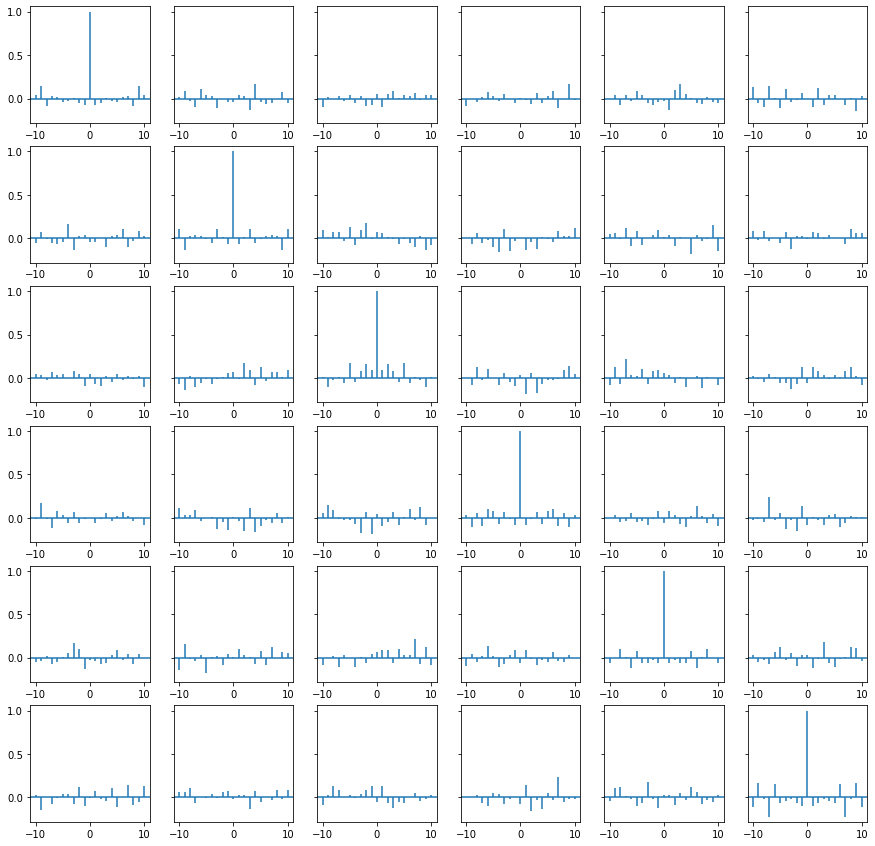

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,-0.078816,-0.054362,0.004786,-0.023657,-0.038999,0.013188,0.032737,-0.083408,0.140859,0.045469
0,1.0,-0.063768,0.012091,0.111109,-0.056979,-0.003829,0.030005,0.033747,0.032272,-0.129004,0.108833
0,1.0,0.088715,0.160778,0.083471,-0.047841,0.170579,-0.055636,0.017243,-0.016857,-0.099063,0.015197
0,1.0,-0.083363,-0.008455,0.066743,-0.06936,0.075079,0.101406,-0.095671,0.05235,-0.104993,0.035415
0,1.0,-0.065491,-0.023669,-0.065018,-0.065908,0.08102,-0.117872,0.00409,0.100429,-0.004668,-0.060261


In [6]:
dim = 6
f, axs = plt.subplots(dim, dim, figsize=(15,15), sharey=True)
print(axs.shape)
timespace = np.linspace(1, len(gendata), len(gendata))
# timespace_2 = np.linspace(1, len(almadf), len(almadf))
# i=0:gendata
lagz=np.arange(start=0, stop=11, dtype=int)
autocorrs_stock = pd.DataFrame(columns=lagz)
for j, cj in enumerate(gendata.columns.tolist()[:dim]):
    for k, ck in enumerate(gendata.columns.tolist()[:dim]):
        lags, correls, a, b = axs[j,k].xcorr(gendata[cj], gendata[ck])
        if j==k:
            acors = correls[len(correls)//2:]
            # print(len(lagz))
            autocorrs_stock = pd.concat([autocorrs_stock,
            pd.DataFrame(np.expand_dims(acors, axis=0), columns=lagz)])

plt.show()
autocorrs_stock.head()


dynPCA with 3 components

(10000, 6)
number of estimated frequencies: 100
dim 0 done
dim 1 done
dim 2 done
dim 3 done
dim 4 done
dim 5 done
length: 100
[[[-3.11885728e-03+0.j  7.80335441e-03+0.j  2.80221086e-02+0.j
    7.91657250e-03+0.j -1.09443236e-02+0.j  9.61834972e-04+0.j]
  [ 1.04382224e-02+0.j -2.27085799e-02+0.j  9.65939835e-03+0.j
   -7.72085087e-03+0.j  8.72873701e-03+0.j  4.43791412e-03+0.j]
  [ 2.21485412e-03+0.j -1.20170936e-02+0.j  4.27750638e-03+0.j
   -1.10527838e-03+0.j -6.74166251e-04+0.j -6.44407189e-03+0.j]
  [-6.61802432e-03+0.j -2.06962368e-03+0.j -4.48517036e-04+0.j
    1.42658688e-02+0.j  2.38695924e-04+0.j -6.88663102e-04+0.j]
  [-7.65196688e-04+0.j  1.07016740e-02+0.j -6.54061092e-03+0.j
   -8.00588168e-03+0.j  1.57697126e-02+0.j -4.68618236e-03+0.j]
  [-5.11150528e-03+0.j  1.77493878e-03+0.j -4.23970353e-03+0.j
    2.18282291e-03+0.j -1.51808397e-03+0.j  1.00495890e-02+0.j]]

 [[ 4.66935046e-04+0.j  1.18024619e-02+0.j -1.96815394e-02+0.j
    1.32963341e-03+0.j -2.80901673e-03+0.j  3.3

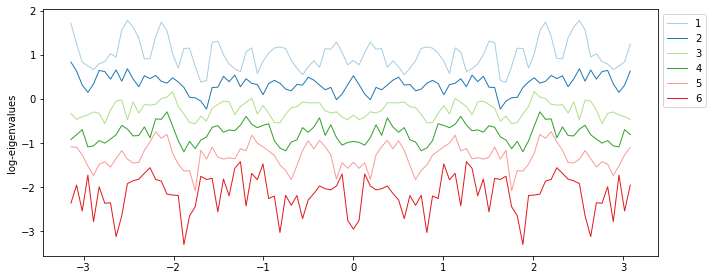

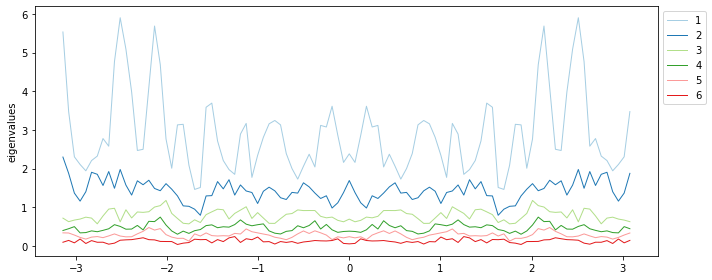

data:  (10000, 6, 1)
PC_dim:  (10000, 3, 1)
sp_array:  (100, 6, 6)
reduced_dim:  (10000, 3, 1)
restored_dim:  (10000, 6, 1)

 Explained variance per dim:
V1    0.863838
V2    0.846922
V3    0.837820
V4    0.860163
V5    0.848627
V6    0.831896
dtype: float64

 Error scores after restoration:
MSE: 0.15000464579678982
MAE: 0.30840279757803424
R2: 0.8499953542032102
Comp. ratio: 0.56
CPU times: user 1.29 s, sys: 506 ms, total: 1.8 s
Wall time: 1.27 s


In [7]:
%%time

# data_subset = pd.DataFrame(np.log(ener_data.iloc[1:,2:].values/ener_data.iloc[:-1,2:].values))
# data_subset = pd.DataFrame(ener_data.iloc[2:,2:].values-ener_data.iloc[1:-1,2:].values)
data_subset = gendata#.iloc[1:,1:]
print(data_subset.shape)
skaler = StandardScaler()
data_subset = pd.DataFrame(skaler.fit_transform(data_subset.values),
                        index=data_subset.index, columns=data_subset.columns)


npers = int(np.sqrt(data_subset.shape[0]))
# npers = int(data_subset.shape[0]/5)
print("number of estimated frequencies: {}".format(npers))


dyn_pca_obj1 = DynPCA(n_components=data_subset.shape[1], densif_method="linear", n_perseg=npers)
dyn_pca_obj1.fit(data_subset, use_M_matrices=True)
dynPCs_all = dyn_pca_obj1.transform(data_subset)

dyn_pca_obj = DynPCA(n_components=3, densif_method="linear", n_perseg=npers)
dyn_pca_obj.fit(data_subset, use_M_matrices=True)

# dyn_pca_obj.plot_eig_vals(log_scale=False, figsize=(15,6))
# plt.show()

dyn_pca_obj.plot_eig_vals(log_scale=True, figsize=(10,4))
plt.show()

dyn_pca_obj.plot_eig_vals(log_scale=False, figsize=(10,4))
plt.show()

dynPCs = dyn_pca_obj.transform(data_subset)
restore = dyn_pca_obj.inverse_transform(dynPCs)

print("\n Explained variance per dim:")
print(np.var(restore)/ np.var(data_subset))

print("\n Error scores after restoration:")
print("MSE: {}".format(mean_squared_error(data_subset, restore)))
print("MAE: {}".format(mean_absolute_error(data_subset, restore)))
print("R2: {}".format(r2_score(data_subset, restore)))

print("Comp. ratio: {}".format(dyn_pca_obj.compression_ratio()))


Estimated spectra on $[0, 2\pi]$

dim 0 done
dim 1 done
dim 2 done
dim 3 done
dim 4 done
dim 5 done
length: 100
[[[-3.11885728e-03+0.j  7.80335441e-03+0.j  2.80221086e-02+0.j
    7.91657250e-03+0.j -1.09443236e-02+0.j  9.61834972e-04+0.j]
  [ 1.04382224e-02+0.j -2.27085799e-02+0.j  9.65939835e-03+0.j
   -7.72085087e-03+0.j  8.72873701e-03+0.j  4.43791412e-03+0.j]
  [ 2.21485412e-03+0.j -1.20170936e-02+0.j  4.27750638e-03+0.j
   -1.10527838e-03+0.j -6.74166251e-04+0.j -6.44407189e-03+0.j]
  [-6.61802432e-03+0.j -2.06962368e-03+0.j -4.48517036e-04+0.j
    1.42658688e-02+0.j  2.38695924e-04+0.j -6.88663102e-04+0.j]
  [-7.65196688e-04+0.j  1.07016740e-02+0.j -6.54061092e-03+0.j
   -8.00588168e-03+0.j  1.57697126e-02+0.j -4.68618236e-03+0.j]
  [-5.11150528e-03+0.j  1.77493878e-03+0.j -4.23970353e-03+0.j
    2.18282291e-03+0.j -1.51808397e-03+0.j  1.00495890e-02+0.j]]

 [[ 4.66935046e-04+0.j  1.18024619e-02+0.j -1.96815394e-02+0.j
    1.32963341e-03+0.j -2.80901673e-03+0.j  3.31720151e-03+0.j]
  [ 3.95278679e-03+0.j  2.44234

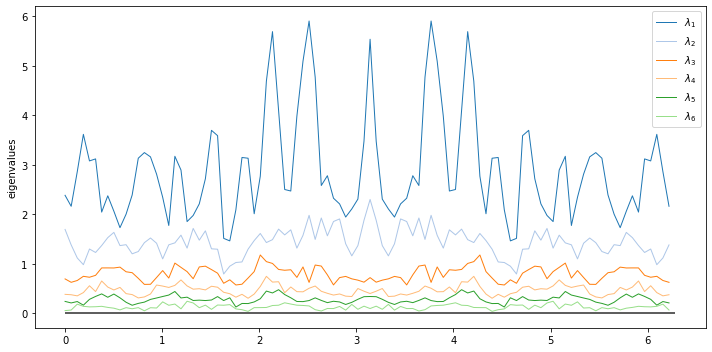

In [8]:
f, ax1 = plt.subplots(1, 1, sharey=True, figsize=(10,5))

freqs, M = lra.bolla_Ms_fast(data_subset, 100)
freqs, M_eig, M_vect = lra.eigen_decomp(M)

print(M_eig.shape)
dimm = 6
orig_dim=6
freqs_o = np.linspace(0, 2*np.pi, 100, endpoint=False)
# for i, rev_i in zip(range(orig_dim-1,-1-(orig_dim-dimm),-1), range(dimm)):
# for i, rev_i in zip(range(orig_dim-1,-1-(orig_dim-dimm),-1), range(dimm)):
for i, rev_i in zip(range(dimm), range(dimm)):
    #ax1.set_title("Eigenvalues of the spectral density esimation on the original time-series")
    ax1.plot(freqs_o, M_eig[:,i],
                label="$\lambda_{}$".format(i+1), linewidth = 1, c=szinek(rev_i))
    print(np.max(M_eig[:,i]), np.min(M_eig[:,i]))
    ax1.hlines(0,0,2*np.pi, linewidth = .3, color="black")
    ax1.legend()

plt.ylabel('eigenvalues')
plt.tight_layout()
if save:
    plt.savefig("simul_eigvals_M.pdf")
plt.show()

Static PCA

In [9]:
%%time

# data_subset = pd.DataFrame(np.log(ener_data.iloc[1:,2:].values/ener_data.iloc[:-1,2:].values))
# data_subset = pd.DataFrame(ener_data.iloc[2:,2:].values-ener_data.iloc[1:-1,2:].values)
data_subset = gendata#.iloc[1:,1:]
print(data_subset.shape)
skaler = StandardScaler()
data_subset = pd.DataFrame(skaler.fit_transform(data_subset.values),
                        index=data_subset.index, columns=data_subset.columns)


# npers = int(np.sqrt(data_subset.shape[0]))
# print("number of estimated frequencies: {}".format(npers))

pca_obj1 = PCA(n_components=data_subset.shape[1])
pca_obj1.fit(data_subset)
PCs_all = pca_obj1.transform(data_subset)
PCs_all =pd.DataFrame(PCs_all, columns=dynPCs_all.columns)


pca_obj = PCA(n_components=3)
pca_obj.fit(data_subset)
# dyn_pca_obj.plot_eig_vals(log_scale=False, figsize=(15,6))
# plt.show()

# dyn_pca_obj.plot_eig_vals(log_scale=True, figsize=(10,4))
# plt.show()

PCs = pca_obj.transform(data_subset)
restore_pca = pca_obj.inverse_transform(PCs)
PCs =pd.DataFrame(PCs, columns=dynPCs.columns)
restore_pca = pd.DataFrame(restore_pca, columns=gendata.columns)

print("\n Explained variance per dim:")
print(np.var(restore_pca)/ np.var(data_subset))

print("\n Error scores after restoration:")
print("MSE: {}".format(mean_squared_error(data_subset, restore_pca)))
print("MAE: {}".format(mean_absolute_error(data_subset, restore_pca)))
print("R2: {}".format(r2_score(data_subset, restore_pca)))

# print("Comp. ratio: {}".format(dyn_pca_obj.compression_ratio()))

(10000, 6)

 Explained variance per dim:
V1    0.739403
V2    0.487333
V3    0.632644
V4    0.474787
V5    0.520734
V6    0.410459
dtype: float64

 Error scores after restoration:
MSE: 0.45577336725394896
MAE: 0.53413469071561
R2: 0.5442266327460512
CPU times: user 185 ms, sys: 747 ms, total: 932 ms
Wall time: 170 ms


function to plot cross-correlations

In [12]:
def plot_crosscorr(df, df2=None, includestock=False, figsize=12, filename=None):
    dim = df.shape[1]
    cols = df.columns.tolist()
    lagz=np.arange(start=0, stop=11, dtype=int)
    autocorrs1 = pd.DataFrame(columns=lagz)
    autocorrs2 = pd.DataFrame(columns=lagz)

    f, axs = plt.subplots(dim, dim, figsize=(figsize, figsize), sharey=True)
    for j, cj in enumerate(cols):
        for k, ck in enumerate(cols):
            lags, correls1, a, b = axs[j,k].xcorr(df[cj], df[ck], lw=2, alpha=0.7)
            if df2 is not None:
                lags, correls2, a, b = axs[j,k].xcorr(df2[cj], df2[ck], color="red", usevlines=False, ms=2, alpha=0.7)
            if includestock:
                lags, correls_stock, a, b = axs[j,k].xcorr(gendata[cj], gendata[ck], color="green", usevlines=False, ms=3, alpha=0.7)
            axs[j,k].grid(True)
            if j==k:
                acors1 = correls1[len(correls1)//2:]
                # print(len(lagz))
                autocorrs1 = pd.concat([autocorrs1,
                pd.DataFrame(np.expand_dims(acors1, axis=0), columns=lagz)])

                acors2 = correls2[len(correls2)//2:]
                # print(len(lagz))
                autocorrs2 = pd.concat([autocorrs2,
                pd.DataFrame(np.expand_dims(acors2, axis=0), columns=lagz)])

    if (filename is not None) and (save == True):
        if isinstance(filename, str):
            plt.savefig(filename)
    plt.show()
    return autocorrs1, autocorrs2

dynPCS against regular PCs

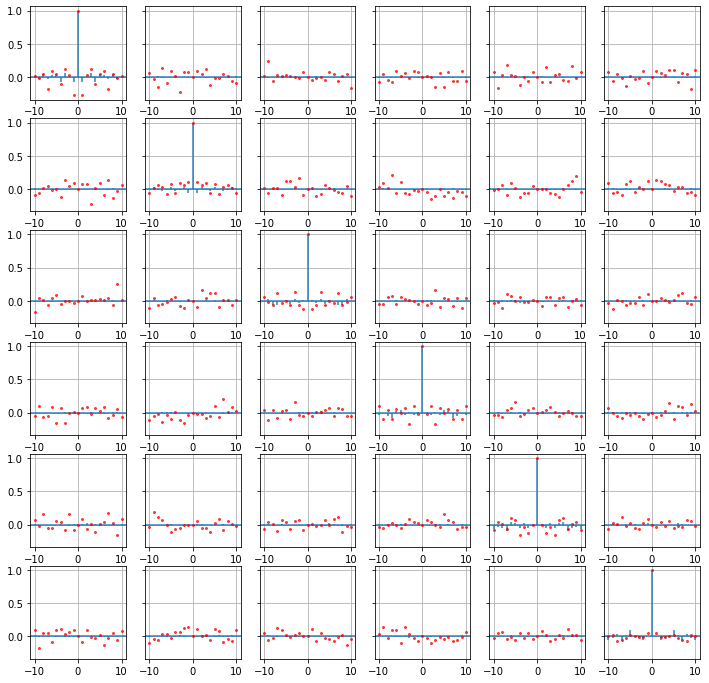

In [13]:
autocorrs1_dpc, autocorrs2_pc = plot_crosscorr(dynPCs_all, PCs_all, figsize=12, filename="PCs_sim.pdf")

restored (from dynPCs) against restored (from PCs)

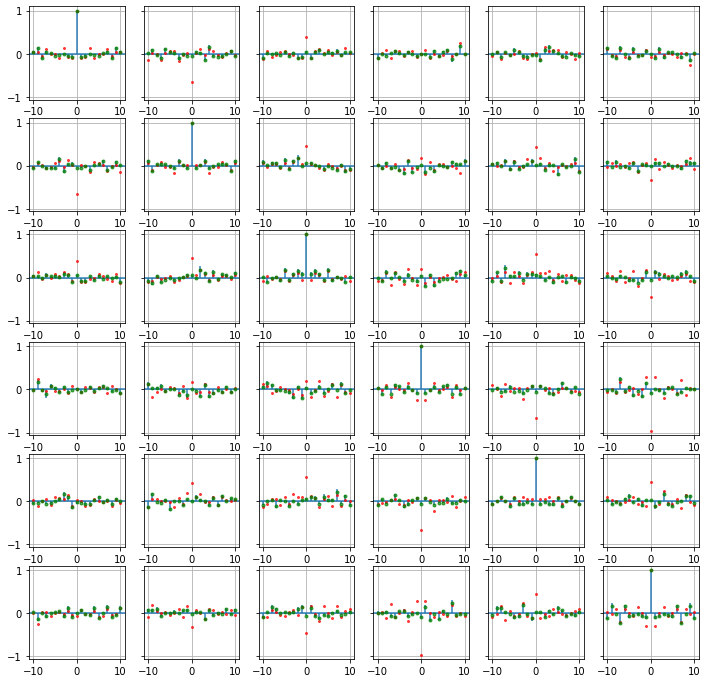

In [14]:
autocorrs1_dre, autocorrs2_re = plot_crosscorr(restore.iloc[:,:], restore_pca.iloc[:,:],
includestock=True, figsize=12, filename="reconstructed_timeseries_sim.pdf")


errors of the reconstructions

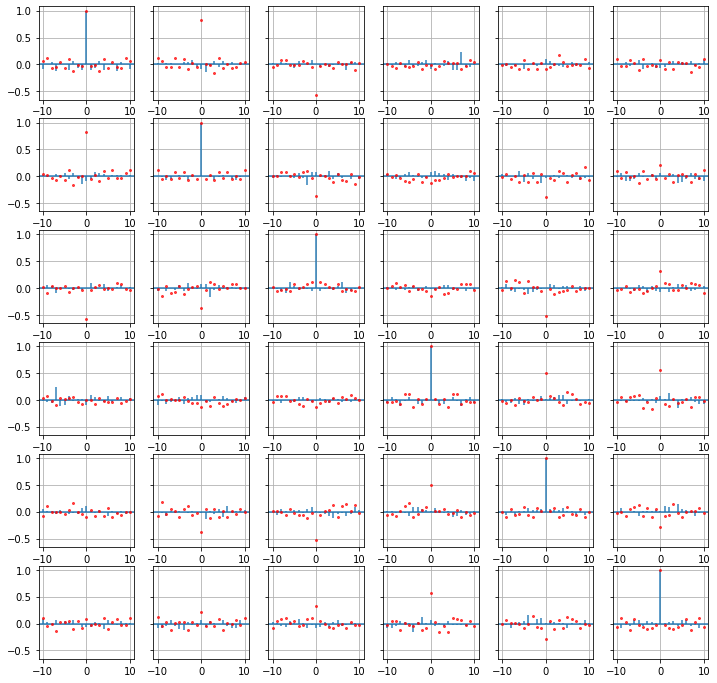

In [15]:
err_pca = gendata - restore_pca
err = gendata - restore

autocorrs1_derr, autocorrs2_err = plot_crosscorr(err.iloc[:,:], err_pca.iloc[:,:],
False, figsize=12, filename="reconst_error_timeseries_sim.pdf")